In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np, os, math, matplotlib.pyplot as plt

In [3]:
TRAIN_DIR = "/content/drive/MyDrive/Datasets/ISIC 2024 Dataset/ISIC_2024_Resize224/train"
TEST_DIR = "/content/drive/MyDrive/Datasets/ISIC 2024 Dataset/ISIC_2024_Resize224/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

test_data = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 12578 files belonging to 2 classes.
Using 10063 files for training.
Found 12578 files belonging to 2 classes.
Using 2515 files for validation.
Found 2000 files belonging to 2 classes.


In [5]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_ds = train_ds.map(normalize_img)
val_ds = val_ds.map(normalize_img)
test_data = test_data.map(normalize_img)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [6]:
classes = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
count_per_class = [len(os.listdir(os.path.join(TRAIN_DIR, c))) for c in classes]

class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(classes)),
    y=np.concatenate([[i]*count for i,count in enumerate(count_per_class)])
)
class_weights = dict(enumerate(class_weights_arr))
print("Clases encontradas:", classes)
print("Pesos calculados para las clases:", class_weights)

Clases encontradas: ['Benign', 'Malignant']
Pesos calculados para las clases: {0: np.float64(1.0), 1: np.float64(1.0)}


In [7]:
input_layer = tf.keras.Input(shape=(224, 224, 3))
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name="data_augmentation")(input_layer) # Aplicamos sobre la entrada
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input(data_augmentation) # Preprocesado para MobileNetV2
base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=preprocess_input)
base_model.trainable = False # Congelamos el modelo base
global_average_layer = layers.GlobalAveragePooling2D()(base_model.output)
dropout_layer = layers.Dropout(0.5)(global_average_layer)
prediction_layer = layers.Dense(1, activation='sigmoid')(dropout_layer) # Salida binaria
model = models.Model(inputs=input_layer, outputs=prediction_layer)

/tmp/ipython-input-1500717002.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=preprocess_input)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 224, 224,  │          0 │ data_augmentatio… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 224, 224,  │          0 │ true_divide[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ subtract[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
)

In [10]:
save_path_v1 = "/content/drive/MyDrive/skin-cancer/saved_models/modelo_benigno_maligno_v1.keras" # Ruta al modelo v1
print(f"Cargando modelo v1 desde: {save_path_v1}")
model = tf.keras.models.load_model(save_path_v1)
print("✅ Modelo v1 cargado.")

Cargando modelo v1 desde: /content/drive/MyDrive/skin-cancer/saved_models/modelo_benigno_maligno_v1.keras
✅ Modelo v1 cargado.


In [ ]:
#No ejecutar
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 2605s 4s/step - accuracy: 0.5013 - loss: 0.7536 - val_accuracy: 0.5062 - val_loss: 0.6821 - learning_rate: 0.0010
Epoch 2/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 621s 985ms/step - accuracy: 0.5345 - loss: 0.6983 - val_accuracy: 0.6525 - val_loss: 0.6709 - learning_rate: 0.0010
Epoch 3/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 627s 996ms/step - accuracy: 0.5441 - loss: 0.6873 - val_accuracy: 0.7455 - val_loss: 0.6632 - learning_rate: 0.0010
Epoch 4/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 623s 990ms/step - accuracy: 0.5539 - loss: 0.6824 - val_accuracy: 0.5646 - val_loss: 0.6624 - learning_rate: 0.0010
Epoch 5/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 664s 1s/step - accuracy: 0.5730 - loss: 0.6754 - val_accuracy: 0.5435 - val_loss: 0.6648 - learning_rate: 0.0010
Epoch 6/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 620s 984ms/step - accuracy: 0.5710 - loss: 0.6732 - val_accuracy: 0.6763 - val_loss: 0.6463 - learning_rate: 0.0010
Epoch 7/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 655s 1s/step - accuracy: 0.59

In [ ]:
#No ejecutar
save_path = "/content/drive/MyDrive/skin-cancer/saved_models/modelo_benigno_maligno_v1.keras"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
model.save(save_path)
print(f"✅ Modelo guardado correctamente en: {save_path}")

NameError: name 'os' is not defined

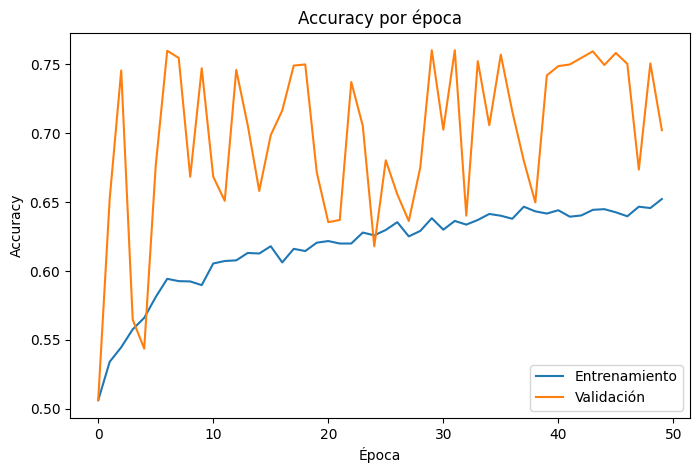

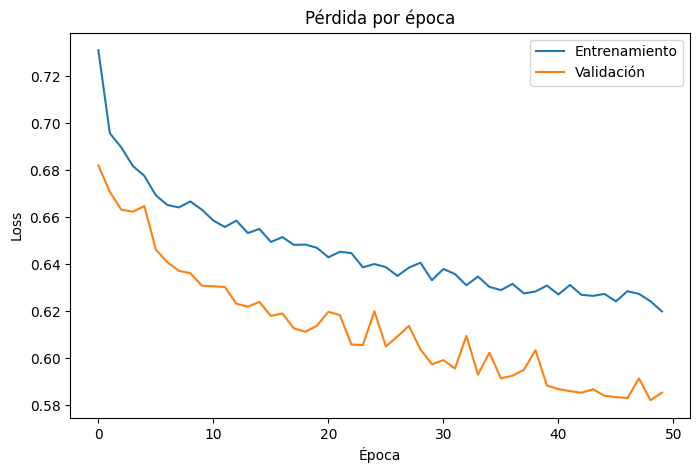

In [ ]:
#No ejecutar
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Accuracy por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
#Preparación para Fine-Tuning
base_model.trainable = True

print(f"Número total de capas en MobileNetV2: {len(base_model.layers)}")

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Número total de capas en MobileNetV2: 155


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 224, 224,  │          0 │ data_augmentatio… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 224, 224,  │          0 │ true_divide[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ subtract[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
print("\nIniciando Fine-Tuning...")

# Entrenamos por unas pocas épocas más
fine_tune_epochs = 20 #(añadir mas epocas)
initial_training_epochs = 50
total_epochs = initial_training_epochs + fine_tune_epochs

early_stop_ft = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Más paciencia
reduce_lr_ft = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=initial_training_epochs,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=[early_stop_ft, reduce_lr_ft]
)
print("Fine-Tuning completado.")


Iniciando Fine-Tuning...
Epoch 51/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 1565s 2s/step - accuracy: 0.6671 - loss: 0.6076 - val_accuracy: 0.7539 - val_loss: 0.5816 - learning_rate: 1.0000e-05
Epoch 52/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.6542 - loss: 0.6153 - val_accuracy: 0.7539 - val_loss: 0.5816 - learning_rate: 1.0000e-05
Epoch 53/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.6553 - loss: 0.6169 - val_accuracy: 0.7547 - val_loss: 0.5816 - learning_rate: 1.0000e-05
Epoch 54/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.6537 - loss: 0.6180 - val_accuracy: 0.7535 - val_loss: 0.5816 - learning_rate: 1.0000e-05
Epoch 55/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.6658 - loss: 0.6110 - val_accuracy: 0.7547 - val_loss: 0.5815 - learning_rate: 1.0000e-05
Epoch 56/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.6531 - loss: 0.6201 - val_accuracy: 0.7535 - val_loss: 0.5815 - learning_rate: 1.0000e-05
Epoch 57/70
629/629 

In [13]:
# Guardar el modelo afinado
save_path_ft = "//content/drive/MyDrive/skin-cancer/saved_models/modelo_benigno_maligno_v2_ft.keras"
os.makedirs(os.path.dirname(save_path_ft), exist_ok=True)
model.save(save_path_ft)
print(f"✅ Modelo afinado guardado correctamente en: {save_path_ft}")

✅ Modelo afinado guardado correctamente en: //content/drive/MyDrive/skin-cancer/saved_models/modelo_benigno_maligno_v2_ft.keras



Gráficos del Fine-Tuning:


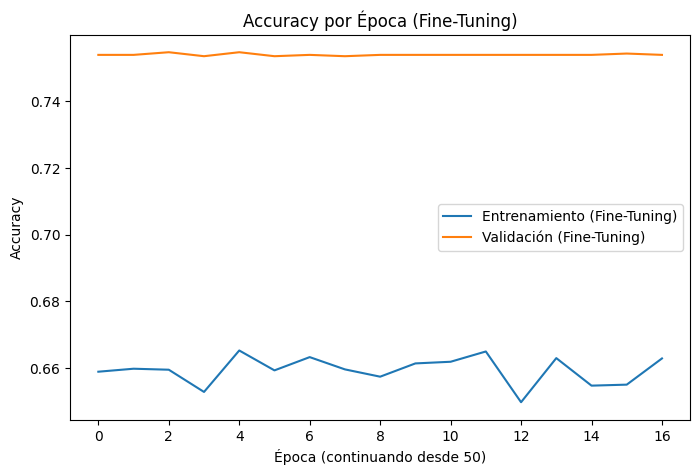

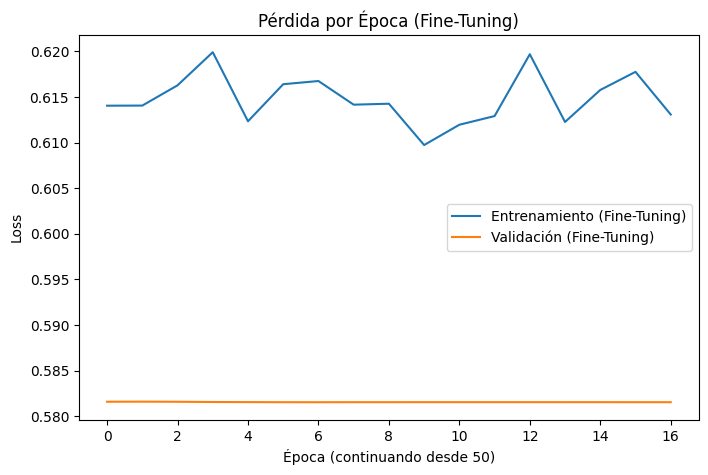

In [14]:
#Graficar los resultados del Fine-Tuning

print("\nGráficos del Fine-Tuning:")

# Gráfico de Precisión (Fine-Tuning)
plt.figure(figsize=(8,5))
plt.plot(history_fine.history['accuracy'], label='Entrenamiento (Fine-Tuning)')
plt.plot(history_fine.history['val_accuracy'], label='Validación (Fine-Tuning)')
plt.title("Accuracy por Época (Fine-Tuning)")
plt.xlabel(f"Época (continuando desde {initial_training_epochs})")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Gráfico de Pérdida (Fine-Tuning)
plt.figure(figsize=(8,5))
plt.plot(history_fine.history['loss'], label='Entrenamiento (Fine-Tuning)')
plt.plot(history_fine.history['val_loss'], label='Validación (Fine-Tuning)')
plt.title("Pérdida por Época (Fine-Tuning)")
plt.xlabel(f"Época (continuando desde {initial_training_epochs})")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
print("\nEvaluando el modelo en el conjunto de prueba:")

loss, accuracy = model.evaluate(test_data)

print(f"\nResultado Final:")
print(f"  - Pérdida (Loss) en prueba: {loss:.4f}")
print(f"  - Precisión (Accuracy) en prueba: {accuracy:.4f} (o {accuracy*100:.2f}%)")


Evaluando el modelo en el conjunto de prueba:
125/125 ━━━━━━━━━━━━━━━━━━━━ 485s 4s/step - accuracy: 0.7862 - loss: 0.5893

Resultado Final:
  - Pérdida (Loss) en prueba: 0.6042
  - Precisión (Accuracy) en prueba: 0.6995 (o 69.95%)
